# Lab: RNNs for Sentiment Analysis (with Attention)
---
- Francisco Landa Ortega
- Diego Hernández Suárez
- Eduardo González Agüero

In this notebook we will add a simple attention layer before the RNNs for Sentiment Analysis.

### PREVIOUS CODE

We load, install and prepare the environment with all the needed dependencies

In [1]:
!pip install --upgrade spacy
import spacy
!python -m spacy download en_core_web_md
import numpy as np
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/datasets/Sentences.txt'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 13.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Mounted at /content/drive


We proceed by reading the reviews, and preprocessing them in order to feed our NN with the appropriate dataset.

In [2]:
with open(file_path, "r", encoding="ISO-8859-1") as sentences:
    lines = sentences.readlines()
phrases = [l.split('@')[0] for l in lines]
opinions = [l.split('@')[1] for l in lines]
def code_opinion(l):
    d = 0
    if (l=='negative\n'):
        d = 1
    elif (l=='positive\n'):
        d = 2
    return d
labels = np.array([code_opinion(l) for l in opinions])
df = pd.DataFrame({"Phrase":phrases,
                  "Opinion":opinions})

We now split into train/test, normalize the reviews and prepare the validation set

In [3]:
from sklearn.model_selection import train_test_split

labels_bin = labels.copy()
labels_bin[labels_bin==2] = 0
idx_data = np.arange(0,len(df),1)
idx_train, idx_test, y_train, y_test = train_test_split(idx_data, labels_bin, test_size=0.2, random_state=0)
idx_train, idx_val, y_train, y_val = train_test_split(idx_train, y_train, test_size=0.2, random_state=0)
acc_baseline_train = np.sum(y_train==0)/y_train.shape[0]

nlp = spacy.load("en_core_web_md")
docs = [nlp(c) for c in phrases]
def normalize(doc):
    return [w for w in doc if w.has_vector and not w.is_punct and not w.is_stop]
norm_docs = [normalize(d) for d in docs]

# List with the length for each sentence
lengths = [len(d) for d in norm_docs]
# Maximum length (in train!)
max_l = np.max([lengths[d] for d in idx_train])
# We add as many junk tokens (#) as needed to equalize the length of each sentence to max_l
garbage_token = nlp('#') # Junk token --> #
# We normalize the dataset
norm_docs_eq_length = [norm_docs[d]+[garbage_token]*(max_l-lengths[d]) for d in range(len(norm_docs))]
# Train documents
docs_train = [norm_docs_eq_length[d] for d in idx_train]
len_train = [lengths[d] for d in idx_train]
# Validation documents
docs_val = [norm_docs_eq_length[d] for d in idx_val]
len_val = [lengths[d] for d in idx_val]
# documents test
docs_test = [norm_docs_eq_length[d] for d in idx_test]
len_test = [lengths[d] for d in idx_test]


We define our class and NN

In [7]:
from torch import nn
from torch import optim
import torch
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,prob=0.5):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        # LSTM layer
        self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, batch_first = True)
        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        # Capa dropout
        self.dropout = nn.Dropout(p=prob)

    def forward(self, x, lengths, h0=None):
        batch_size = x.size(0)
        seq_length = x.size(1)
        r_out, _ =  self.rnn(x)
        aux = torch.stack([r_out[d,lengths[d] - 1, :] for d in range(batch_size)]).reshape([-1,self.hidden_dim])
        aux = self.dropout(aux)
        output = self.logsoftmax(self.fc1(aux))
        return output

class RNN_with_train(RNN):
    def __init__(self,input_size, output_size, hidden_dim, n_layers,prob=0.0,batch_size=50,lr=0.0005,saved_files='/content/drive/My Drive/datasets/RNN_sentiment_analysis'):
        super().__init__(input_size, output_size, hidden_dim, n_layers,prob)
        self.lr = lr # Learning Rate
        self.optim = optim.Adam(self.parameters(), self.lr) # Optimizer
        self.criterion = nn.NLLLoss()
        self.loss_during_training = []
        self.valid_loss_during_training = []
        self.batch_size = batch_size
        self.saved_files = saved_files

    def predict_proba(self,docs,lengths,Y=None):
        accuracy = 0.0
        with torch.no_grad():
            x_input = torch.Tensor([[w.vector for w in d] for d in docs])
            logprobs = self.forward(x_input,lengths).detach().numpy() # CUIDAOOOOOO
            if(len(Y)>0):
                accuracy = np.sum(np.argmax(logprobs,1)==Y)/np.shape(Y)[0]
        return logprobs,accuracy

    def fit(self,docs_train,docs_val,Y,Yval,len_train,len_val,epochs=100,print_every=5):
        self.print_every = print_every
        self.epochs=epochs
        self.num_train = len(docs_train) # Number of training points
        self.num_batchs = np.floor(self.num_train/self.batch_size) # Number of training batches
        self.num_val = len(docs_val) # Number of validation points
        self.num_batchs_val = np.floor(self.num_val/self.batch_size) # Numero of validation batches
        labels = torch.Tensor(Y).type(torch.LongTensor) # Training labels
        labelsval = torch.Tensor(Yval).type(torch.LongTensor) # Validation labels
        for e in range(int(self.epochs)):
            self.train()
            idx = np.random.permutation(self.num_train)
            running_loss = 0.
            for i in range(int(self.num_batchs)):
                self.optim.zero_grad()
                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]
                idx_batch = [d for d in idx_batch if len_train[d]>0]
                x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx_batch])
                out = self.forward(x_input,[len_train[d] for d in idx_batch])
                loss = self.criterion(out,labels[idx_batch])
                running_loss += loss.item()
                loss.backward()
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                self.optim.step()
            self.loss_during_training.append(running_loss/self.num_batchs)
            torch.save(self.state_dict(), self.saved_files+'_epoch_'+str(e)+'.pth')
            with torch.no_grad():
                self.eval()
                running_loss = 0.
                idx = np.random.permutation(self.num_val)
                running_loss = 0.
                for i in range(int(self.num_batchs_val)):
                    idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]
                    # Just in case there are empty documents, we ignore them
                    idx_batch = [d for d in idx_batch if len_val[d]>0]
                    x_input = torch.Tensor([[w.vector for w in docs_val[d]] for d in idx_batch])
                    out = self.forward(x_input,[len_val[d] for d in idx_batch])
                    loss = self.criterion(out,labelsval[idx_batch])
                    running_loss += loss.item()
                self.valid_loss_during_training.append(running_loss/self.num_batchs_val)
            if(e % self.print_every == 0):
                print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}")

### Implementating the attention mechanism
First, we are going to define the class and implement it. Then, after some analysis with plots, we are going to check how the old models (without any training, and with training but without attention) perform, and do some comparative analysis.

In [8]:
import torch.nn.functional as F

class RNN_with_attention(RNN_with_train):

    def __init__(self, input_size, output_size, hidden_dim, n_layers, prob=0.0, batch_size=50, lr=0.0005, saved_files='/content/drive/My Drive/datasets/RNN_sentiment_analysis'):
        super().__init__(input_size, output_size, hidden_dim, n_layers, prob, batch_size, lr, saved_files)

        # Define the attention MLP layers
        self.attention_layer1 = nn.Linear(hidden_dim, hidden_dim)
        self.attention_layer2 = nn.Linear(hidden_dim, 1)

    def forward(self, x, lengths, h0=None):
        '''
        - x: Sequences of word embeddings. Dimensions (batch_size, max_l, word_embedding_size)
        - lengths: The real length of each sequence, excluding the junk # tokens! You use this to know what
          RNN state you should use to classify
        '''

        batch_size = x.size(0)
        seq_length = x.size(1)

        r_out, _ =  self.rnn(x)

        aux = torch.stack([r_out[d, lengths[d] - 1, :] for d in range(batch_size)]).reshape([-1, self.hidden_dim])

        # Apply attention mechanism
        att = torch.tanh(self.attention_layer1(r_out))
        att = self.attention_layer2(att)
        att = F.softmax(att.squeeze(), dim=1)

        # Weighted sum of RNN outputs based on attention
        weighted_sum = torch.bmm(att.unsqueeze(1), r_out).squeeze()

        # We classify using the weighted sum tensor (don't forget the dropout!)
        weighted_sum = self.dropout(weighted_sum)
        output = self.logsoftmax(self.fc1(weighted_sum))

        return output

We instantiate the model, train and evaluate the test set on the Network to see how it performs

<ipython-input-7-119fe49d769e>:63: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx_batch])


Training loss after 0 epochs: 0.4702519880582208. Validation loss: 0.39061806599299115
Training loss after 5 epochs: 0.29320136876138925. Validation loss: 0.2806481611397531
Training loss after 10 epochs: 0.2234889637321642. Validation loss: 0.2423107847571373
Training loss after 15 epochs: 0.15456625803896826. Validation loss: 0.1897280514240265
Training loss after 20 epochs: 0.11125764311992958. Validation loss: 0.16696026879880163
Training loss after 25 epochs: 0.08242595486649096. Validation loss: 0.1599309965968132
Training loss after 30 epochs: 0.06166119263698793. Validation loss: 0.16059209333939684
Training loss after 35 epochs: 0.05348777593662069. Validation loss: 0.15027941530570388


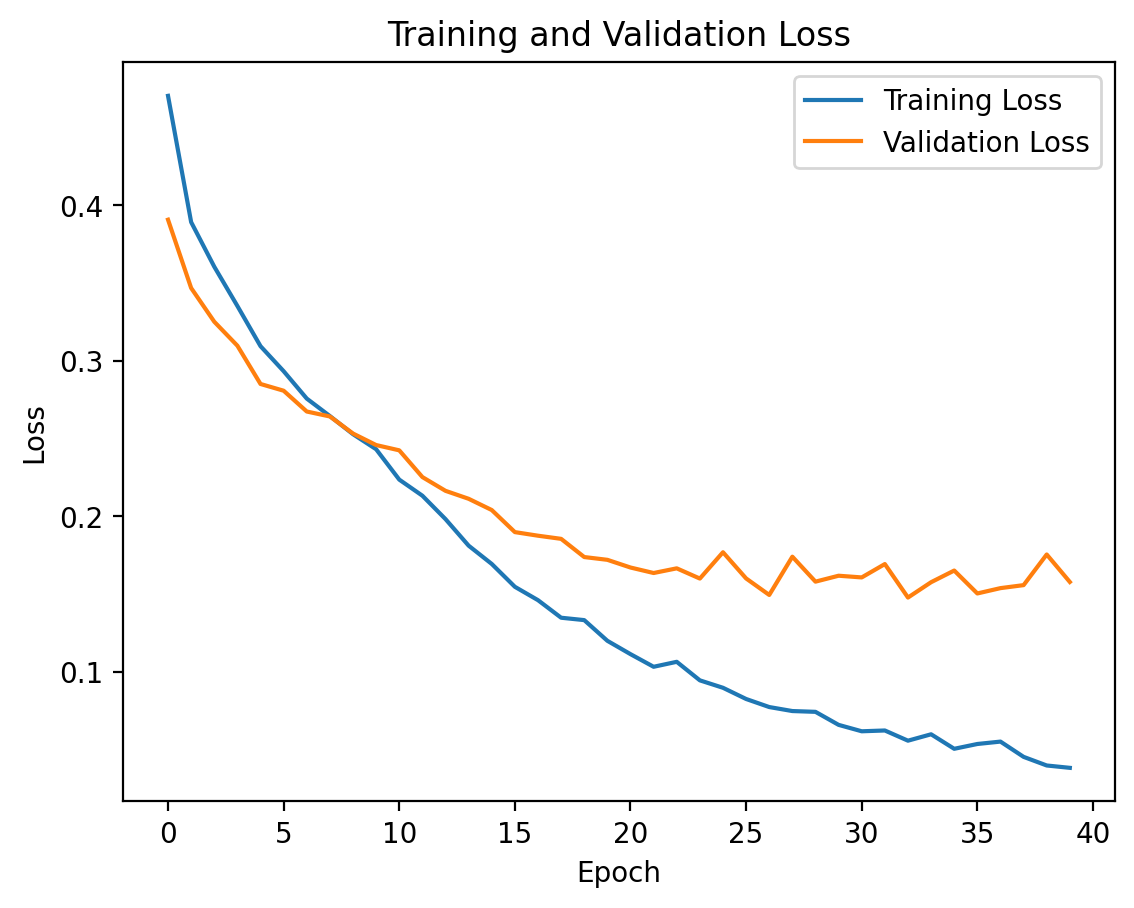

The test accuracy for RNN_with_attention is 0.9554195804195804


In [9]:
my_RNN_with_attention = RNN_with_attention(input_size=300,
                                            output_size=2,
                                            hidden_dim=20,
                                            n_layers=1,
                                            prob=0.3,
                                            batch_size=50,
                                            lr=0.0005)

# Train the RNN_with_attention model
my_RNN_with_attention.fit(docs_train, docs_val, torch.Tensor(y_train), torch.Tensor(y_val), len_train, len_val, epochs=40, print_every=5)

# Plotting the train/val loss
plt.plot(my_RNN_with_attention.loss_during_training, label='Training Loss')
plt.plot(my_RNN_with_attention.valid_loss_during_training, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Find the epoch with the lowest validation loss
best_epoch = np.argmin(my_RNN_with_attention.valid_loss_during_training)

# Load the model parameters corresponding to the epoch with the lowest validation loss
state_dict = my_RNN_with_attention.load_state_dict(torch.load(f'/content/drive/My Drive/datasets/RNN_sentiment_analysis_epoch_{best_epoch}.pth'))

# Evaluate the model on the test set
logprobs, acc = my_RNN_with_attention.predict_proba(docs_test, len_test, y_test)
probs = np.exp(logprobs)

# Print the test accuracy
print(f"The test accuracy for RNN_with_attention is {acc}")



The previous plot compares training and validation loss for our RNN with an
attention mechannism. Performance is clearly great, with test accuracy of 0.9554. We can also see that we are training with an excessive amount of epochs: for validation (the one we're interested in), loss stabilizes at under 0.2 after the 20th epoch. This algorithm is quite costly to implement (takes some minutes), and it would seem half our training time is redundant.

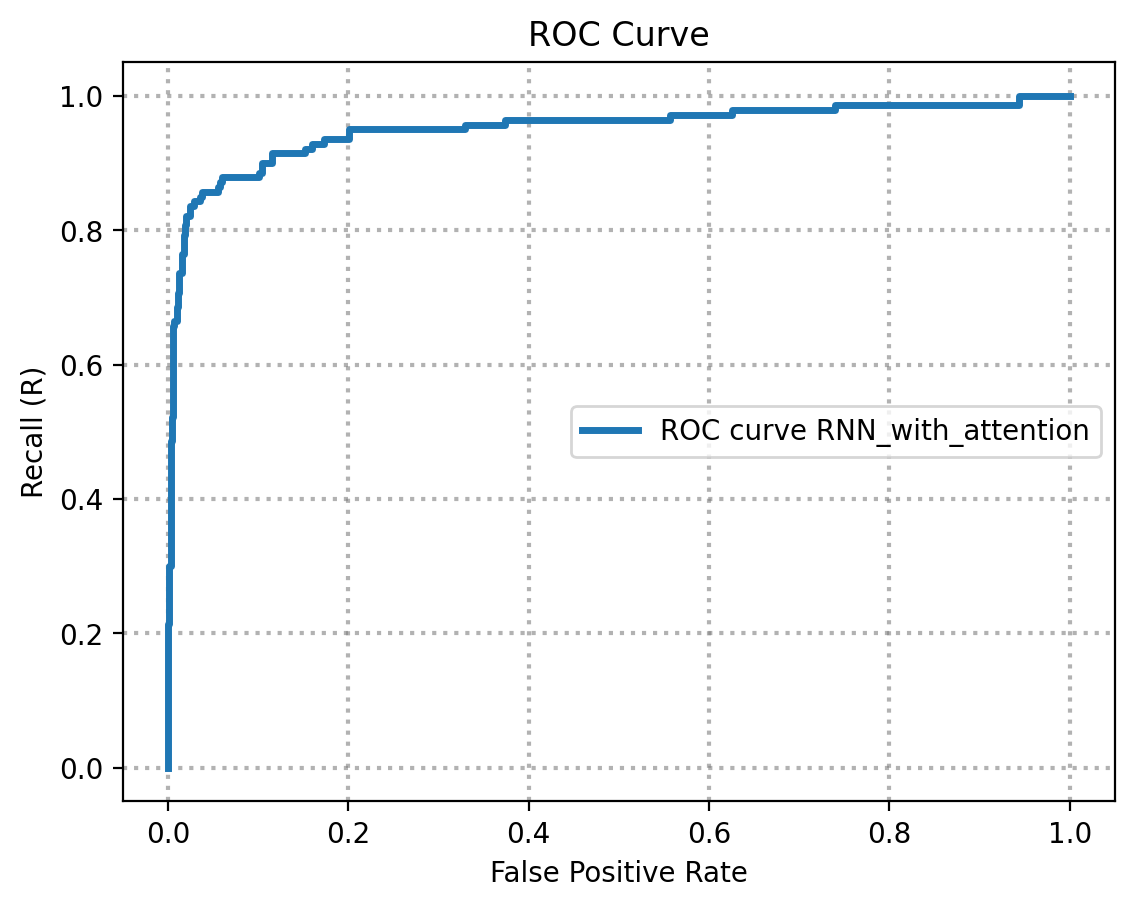

AUC ROC for RNN_with_attention is 0.9514371087080251


In [10]:
from sklearn import metrics
# Plot the ROC curve
fpr, recall, thresholds = metrics.roc_curve(y_test, probs[:,1], pos_label=1)

fig, ax = plt.subplots()
plt.plot(fpr, recall, lw=2.5, label='ROC curve RNN_with_attention')
plt.legend(loc=7)
plt.grid(axis='both', which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('ROC Curve')
plt.show()

# Compute the AUC ROC
area_roc_RNN_with_attention = metrics.roc_auc_score(y_test, probs[:,1])
print(f"AUC ROC for RNN_with_attention is {area_roc_RNN_with_attention}")


Our plot for the ROC curve shows in another way the good performance of our model. Where the worst possible scenario is a straigth line going from (0,0) to (1,1) (the model is essentially no better than tossing a coin to decide how to classify values), the shape of the curve suggests a great performance.

---
Now, we will run the model we completed in the previous notebook, which is a simple NN, using LSTM.

In [11]:
my_RNN = RNN_with_train(input_size = 300,
                        output_size = 2,
                        hidden_dim=20,
                        n_layers=1,
                        prob = 0.3,
                        batch_size = 50,
                        lr = 0.0005)

#Call train

my_RNN.fit(docs_train,docs_val,torch.Tensor(y_train),torch.Tensor(y_val),len_train,len_val,epochs=40,print_every=5)

Training loss after 0 epochs: 0.5219050911191392. Validation loss: 0.39168400565783185
Training loss after 5 epochs: 0.27975905594760425. Validation loss: 0.29424866868389976
Training loss after 10 epochs: 0.22653063488741443. Validation loss: 0.2803828939795494
Training loss after 15 epochs: 0.19161251024024128. Validation loss: 0.2594014335837629
Training loss after 20 epochs: 0.1509489009335433. Validation loss: 0.24801635618011156
Training loss after 25 epochs: 0.12306807736215526. Validation loss: 0.23447375992933908
Training loss after 30 epochs: 0.1049680855278283. Validation loss: 0.2157019753423002
Training loss after 35 epochs: 0.08232739384043707. Validation loss: 0.19644686662488514


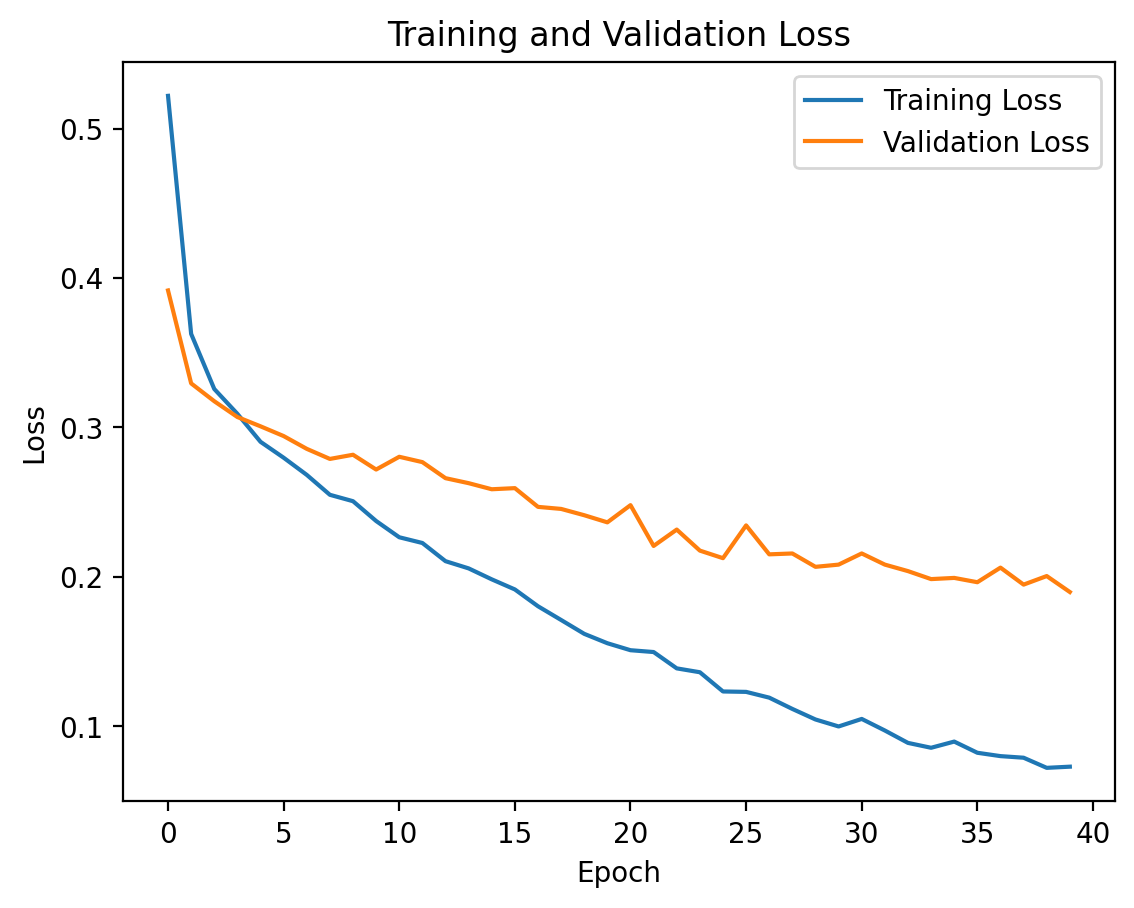

In [12]:
# Plotting the train/val loss
plt.plot(my_RNN.loss_during_training, label='Training Loss')
plt.plot(my_RNN.valid_loss_during_training, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Recover the model parameters for the epoch that minimized the validation loss
best_epoch = np.argmin(my_RNN.valid_loss_during_training)  # Find the epoch with the lowest validation loss
state_dict = my_RNN.load_state_dict(torch.load(f'/content/drive/My Drive/datasets/RNN_sentiment_analysis_epoch_{best_epoch}.pth'))


Looking at this plot, we can see right away some difference with the performance of the attention model. Namely, the rapid overfitting (training loss is lower than validation loss at the fourth iteration), and that after 40 iterations, the validation loss doesn't seem to stabilize; i.e, it would require more than twice the amount of epochs than the attention model to properly train. Still, at 40th iteration, the model is also under 0.2 validation loss.

The test accuracy is 0.9344405594405595


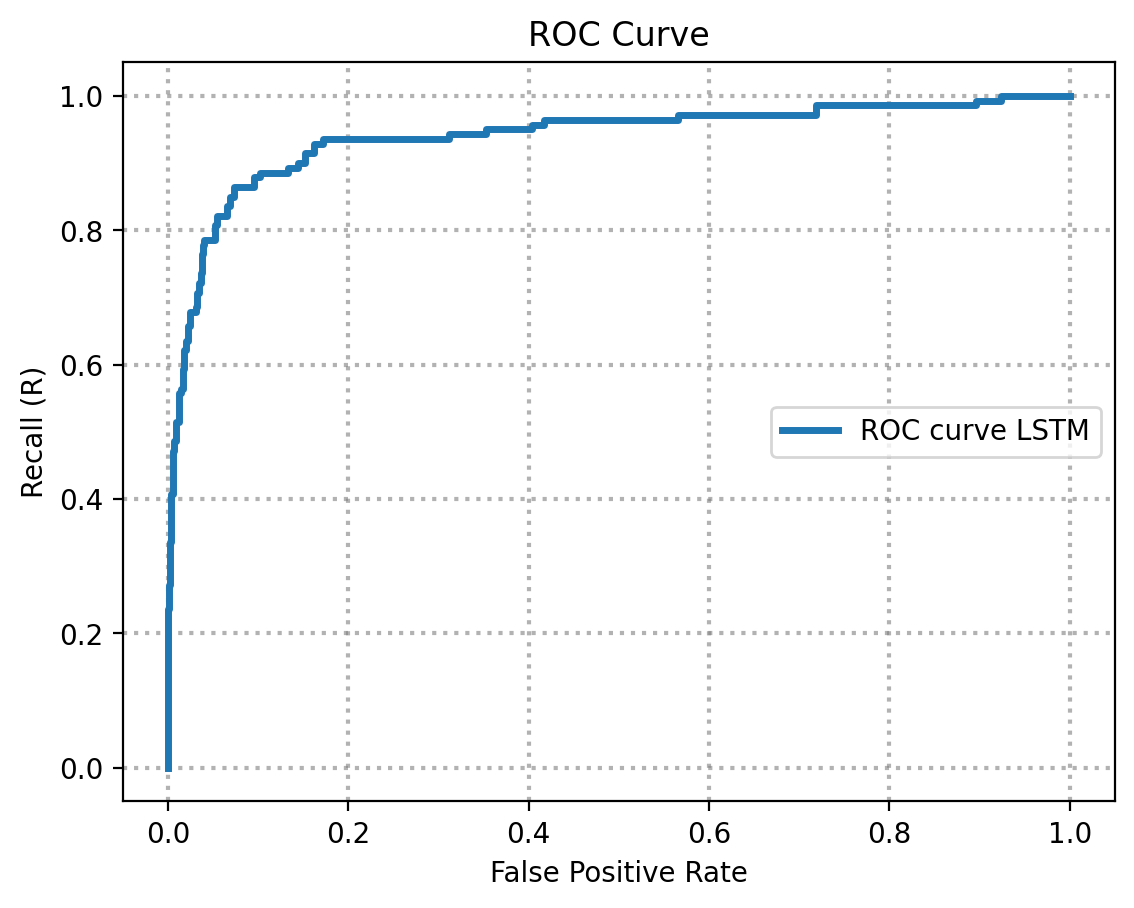

AUC ROC for LSTM is 0.9396556630620376


In [13]:
# Recovering the best validation parameters
idx_min = np.argsort(my_RNN.valid_loss_during_training)
best_epoch = idx_min[0]

# Load the model parameters corresponding to the epoch with the lowest validation loss
state_dict = my_RNN.load_state_dict(torch.load(f'/content/drive/My Drive/datasets/RNN_sentiment_analysis_epoch_{best_epoch}.pth'))
logprobs, acc = my_RNN.predict_proba(docs_test, len_test, y_test)
probs = np.exp(logprobs)

# Print the test accuracy
print(f"The test accuracy is {acc}")
from sklearn import metrics

fpr, recall, thresholds = metrics.roc_curve(y_test, probs[:,1], pos_label=1)

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='ROC curve LSTM')
plt.legend(loc=7)
plt.grid(axis='both', which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('ROC Curve')
plt.show()

area_roc_LSTM = metrics.roc_auc_score(y_test, probs[:,1])

print(f"AUC ROC for LSTM is {area_roc_LSTM}")

What we see here is, essentially, that the classification performance is almost as good for the attention model (.9554) than for the non-attention model (0.9344). So, what is the key difference? Training! Both models perform roughly the same, but the attention model is "getting there" in half as many epochs as the non-attention model. For a small task like the one we have just performed, this difference may just be apparent in hindsight, but if one were dealing with a much larger, critical dataset, for example, this difference would become *vital*.